In [1]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

import matplotlib
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
#import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
data=pd.read_csv ("uci-news-aggregator.csv")

data.TITLE=data.TITLE.str.lower()
data["simple_text"]=data.TITLE.str.replace("[^a-zA-Z0-9]", " ", regex=True)
data["simple_text"]=data.simple_text.str.replace('\s+', ' ', regex=True)


#data.groupby('CATEGORY').agg({'CATEGORY':'size'})
data.CATEGORY.value_counts()


e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

In [3]:
# pull the data into vectors
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(data['simple_text'])
#splits simple_text and matches uniquely each word to a number in 

print(len(vectorizer.vocabulary_))


encoder = LabelEncoder()

y = encoder.fit_transform(data['CATEGORY']) 
#matches each category value to a number


# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# take a look at the shape of each of these
#print(encoder.classes_)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



54420
(337935, 54420)
(337935,)
(84484, 54420)
(84484,)


In [4]:
#the classifier
nb = MultinomialNB()
nb.fit(x_train, y_train)
nb.score(x_test, y_test)

MultinomialNB()

0.9264831210643435

In [5]:
#let's try the classifier
xtry = vectorizer.transform(['kim kardashian','fed banks','samsung galaxy','dow jones','ebola virus'])

encoder.inverse_transform(nb.predict(xtry))
#print(xtry)

array(['e', 'b', 't', 'b', 'm'], dtype=object)

In [6]:

#let s try after removing stopwords

vectorizer_stop = CountVectorizer(stop_words='english') 
x_stop = vectorizer_stop.fit_transform(data['simple_text'])

x_train, x_test, y_train, y_test = train_test_split(x_stop, y, test_size=0.2)

print(len(vectorizer_stop.vocabulary_))



54128


In [7]:
nb = MultinomialNB()
nb.fit(x_train, y_train)
nb.score(x_test, y_test)



MultinomialNB()

0.9283532976658302

In [8]:
#a function that produces a wordcloud given a column of strings and stopwords
def freq_words(corpus,stopwords):
    all_words = ' '.join([text for text in corpus])
    #all_words = all_words.split()
    

    fig = plt.figure(figsize=(21,16))
    ax1 = fig.add_subplot(2,1,1)
    wordcloud = WordCloud(stopwords=stopwords,width=1000, height=300, background_color='white', 
                          max_words=1628, relative_scaling=1,
                          include_numbers=True,
                          normalize_plurals=True).generate(all_words)
    
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off') 
    plt.show()


  

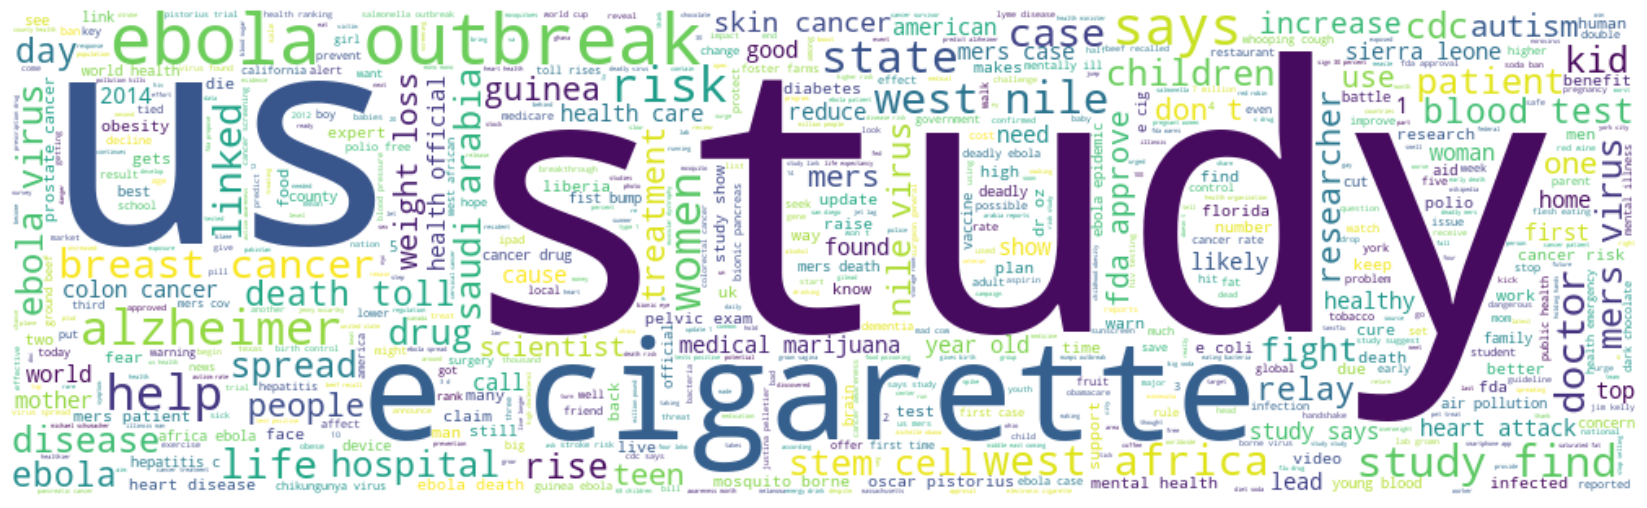

In [9]:
stopwords=STOPWORDS
stopwords.update(["new", "say", "may",'report','make','take','continue','will','u','now','s'])   
    
freq_words (data[data.CATEGORY=='m'].simple_text,stopwords=stopwords) 
#m category seems related to health

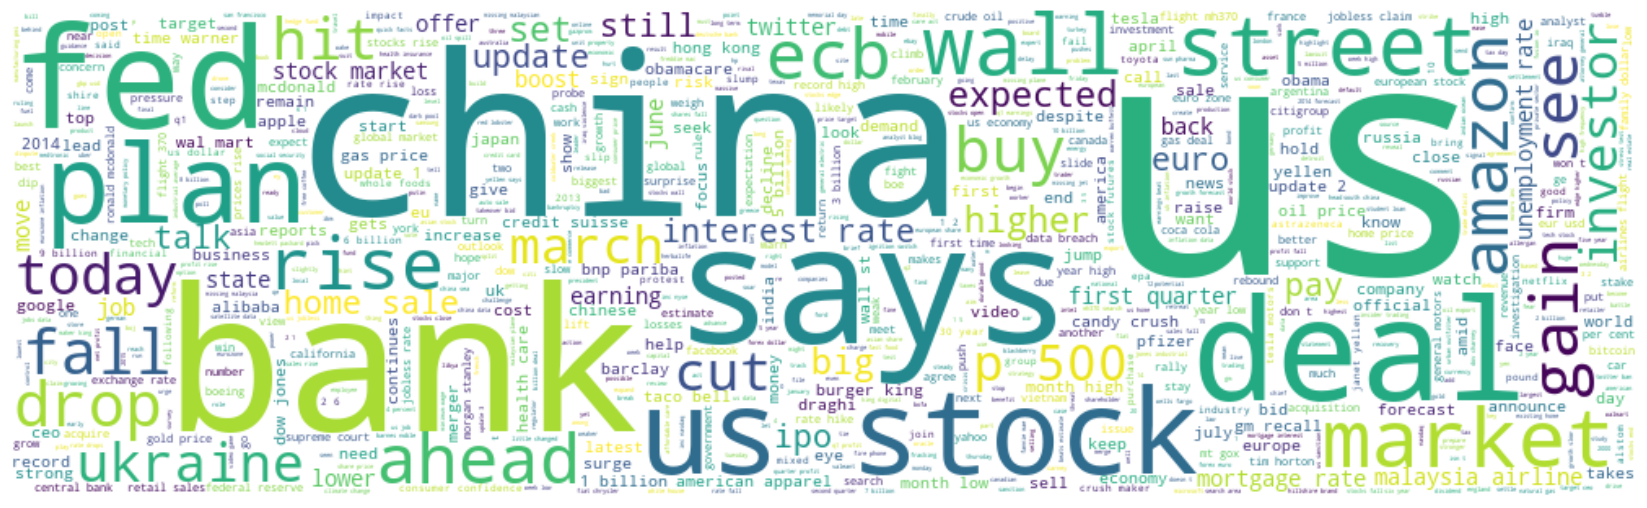

In [10]:
freq_words (data[data.CATEGORY=='b'].simple_text,stopwords=stopwords)

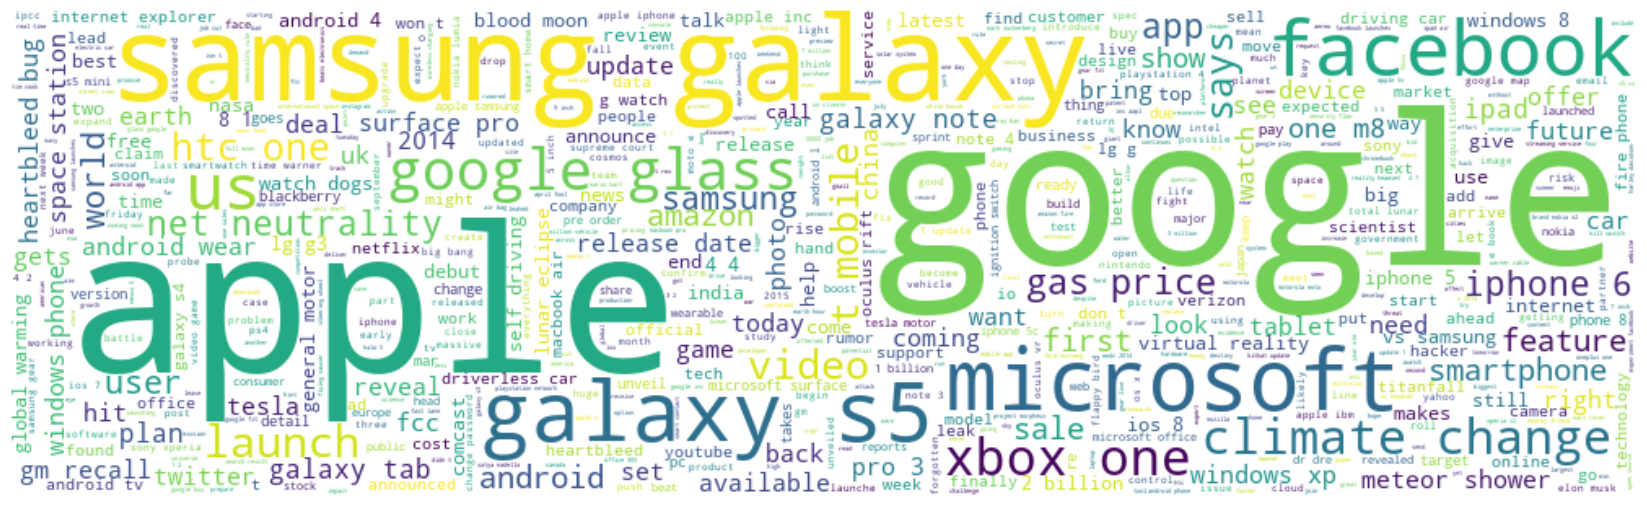

In [11]:
freq_words (data[data.CATEGORY=='t'].simple_text,stopwords=stopwords)

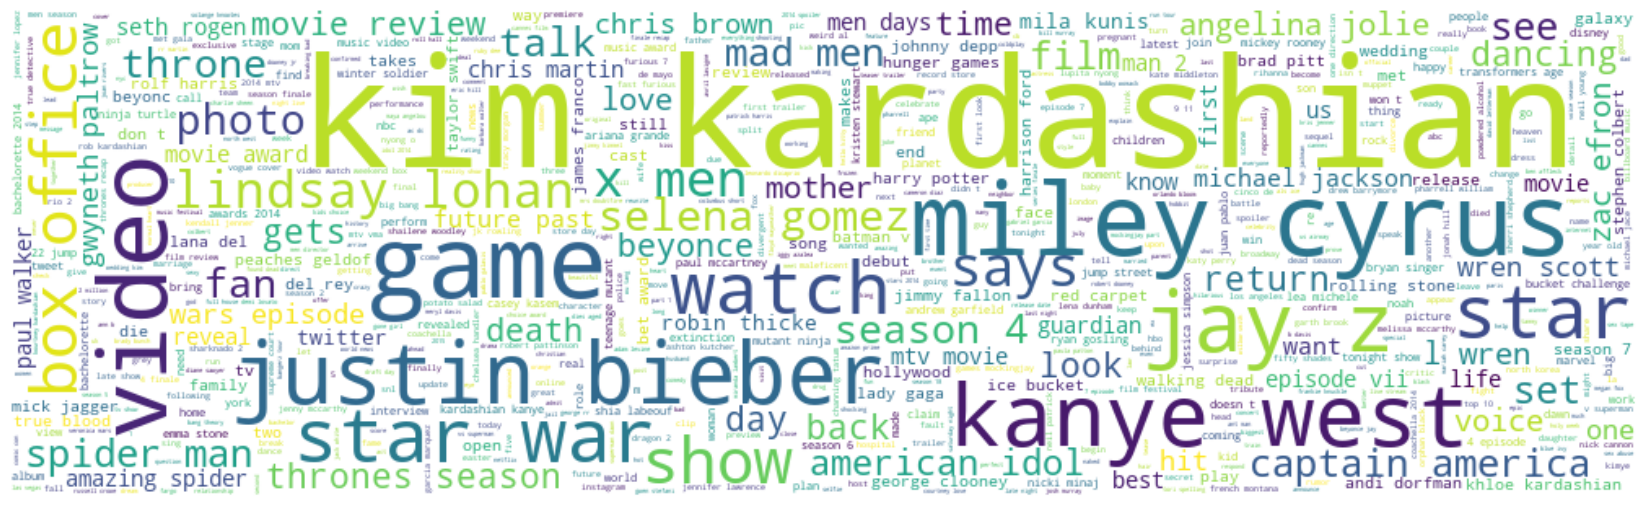

In [12]:
freq_words (data[data.CATEGORY=='e'].simple_text,stopwords=stopwords)

The wordclouds didn't give a lot of ideas about the actual things that happend. I will try combinations of words or n-grams.  

1-grams or unigrams are similar to the wordcloud results so bigrams or higher will be presented.

In [13]:
#a function that finds the n most common n-grams


def get_top_n_words(corpus,ngram=1, n=5):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(corpus)
    all_words = vec.transform(corpus)
    sum_words = all_words.sum(axis=0) 
    word_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]


In [14]:
# function that creates a chart with the n most common n-grams

def top_phrases_chart(corpus,ngram=1, n=5,titlestring=''):

    common_words = get_top_n_words(corpus,ngram=ngram, n=n)
    df = pd.DataFrame(common_words, columns = ['simple_text' , 'count'])
    return (df.groupby('simple_text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title=f'Top {n} {ngram}-grams in titles {titlestring}'))
    


In [20]:
#entetainment news will be excluded
for x in range(2,5):
    top_phrases_chart(data.simple_text[data.CATEGORY!='e'],ngram=x, n=20,titlestring='of non-entertainment news')

In [16]:

for x in range(2,5):
    top_phrases_chart(data.simple_text[data.CATEGORY=='b'],ngram=x, n=20, titlestring='of business news')

In [17]:
for x in range(2,4):
    top_phrases_chart(data.simple_text[data.CATEGORY=='m'],ngram=x, n=20, titlestring='in health')


### Actionable recommendations: 

If we need to support new mobile phones it would make sense to start with Samsung galaxy xx models. 
Moreover, since Samsung seems to dominate the news (probably paid) and tends to try to be independent from google in many areas (samsung pay instead of google pay,Samsung free as opposed to chrome cast-google home) there could be an opening to them wanting to go with tomtom's maps instead of google. Especially if we can prove that samsung users who drive drive cars from tomtom's brand porfolio. 
Keep in mind that a tomtom-related article with samsung would be shown as relevant ('similar news' is a component used by many news platforms) to samsung's already huge number of articles.  
Moreover we should probably look for compatibility with self-driving car(s) and advertise it as it tends to make the news. It could be a great headline that the 1st mass produced self driving car uses TomTom's real time map.


### Some interesting events that happened:


-GM recalled millions of cars.  
-West nile virus  
-galaxy s5  
-malaysia airlines flight disappeareance  
-there are a lot of headlines about home sales, mortgages (fannie mae freddie mac) is also related to it.
from the above we can extrapolate that the news are from 2014 and the majority come from US news sources.